In [1]:
import pickle
import matplotlib.pyplot as plt
import igraph as ig
import os
from tqdm import tqdm

In [9]:
# Matplotlib defaults

font = {"family" : "normal",
    "size" : 22}

plt.rcParams.update({"font.size" : 22})

plt.style.use("dark_background")

# Analyze fragment diversity

Do fragments change as MA increases?

## Test 1: number of fragments over time

In [3]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

In [4]:
""" NewFrags holds fragments within the new compound sample, 
    while FullFrags is for fragments in the full database sample (regardless of naming files
    within it "newFrags", that was a file output error)
"""

def get_monthly_frags(month):
    return pickle.load(file=open("Data/AssemblyValues/Fragments/FullFrags/newFrags_" + month + ".p", "rb"))


In [5]:
months = build_month_increments(1980, 2019)

frags = []

for month in months:
    frags.append(get_monthly_frags(month))

In [6]:
#Graph number of fragments over time
sizes = []
for month_frags in frags:
    sizes.append(len(month_frags))

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

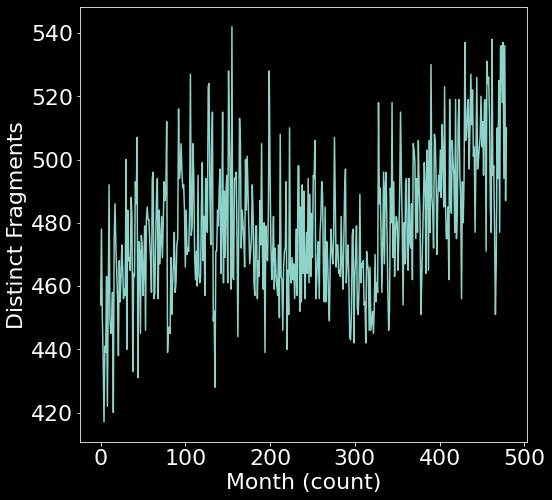

In [10]:
    """ General thought - small increase, but not definitive
    """

plt.figure(figsize=(8,8))

plt.plot(sizes)

plt.xlabel("Month (count)")
plt.ylabel("Distinct Fragments")

plt.show()

## Step 2: different _types_ of fragments

Are there increasing numbers of different types (aka those not seen before) as time increases?

In [11]:
## Get a master list of fragments (starting with 1980-01)

all_frags = frags[0] #1980-01 fragments

In [12]:
## Testing: find new fragments in 1980-02, and count the number of additions

months = build_month_increments(1980, 2019)
new_frag_count = []

for i in tqdm(range(1, len(frags))):
    new_frags = 0
    current_allfrags_size = len(all_frags)

    #Test all monthly fragments...
    for candidate_f in frags[i]:
    
        is_unique = True

        #...against all unique fragments...
        for frag in all_frags[:current_allfrags_size]:
            if candidate_f.isomorphic_vf2(frag,
                                            color1=candidate_f.vs["color"],
                                            color2=frag.vs["color"],
                                            edge_color1=candidate_f.es["color"],
                                            edge_color2=frag.es["color"]):
                #...if candidate is isomorphic, it is not unique, therefore break off check...
                is_unique = False
                break
        
        #...if it makes it through the full list of fragments, it is unique!
        if is_unique:
            all_frags.append(candidate_f)
            new_frags += 1

    new_frag_count.append(new_frags)


100%|██████████| 479/479 [5:30:04<00:00, 41.35s/it]  


In [15]:
import pickle

pickle.dump(all_frags, file=open("Data/AssemblyValues/Fragments/full_fragment_data.p", "wb"))

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

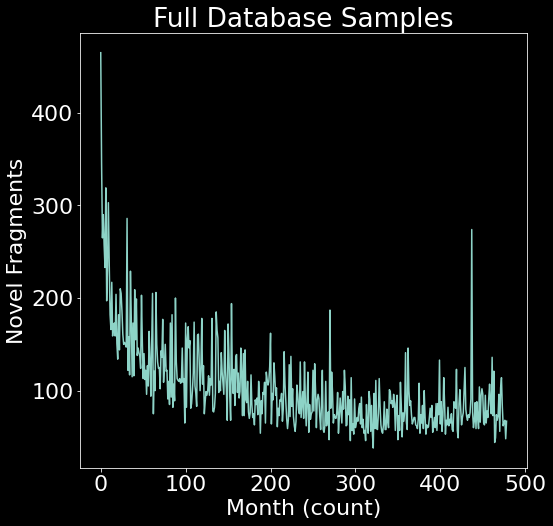

In [14]:
plt.figure(figsize=(8,8))

plt.plot(new_frag_count)

plt.xlabel("Month (count)")
plt.ylabel("Novel Fragments")
plt.title("Full Database Samples")

plt.show()